In [55]:
import numpy as np
from scipy.special import gammainc, gamma
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.integrate import quad
from scipy.stats import poisson
from tqdm import tqdm   
from random import choices
from collections import Counter
from scipy.optimize import curve_fit

## Juan Notes:
* I would like a docstring for how singleAtom works. We've been using the google standard for dev on the cspy project, looks like we'll be adopting it as a lab so use that.
    - google standard styleguide, info on docstrings is section 3.8 : http://google.github.io/styleguide/pyguide.html
    - google standard examples : https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html
* units for values set?
* the first term in your lambda function is causing decays of counts to zero. They need to decay into the background rate
* I like what you've done here, but I would like to be able to understand at a glance. Could you put a latex explanation of the math you're doing up here?

The rate of photon emission from a single atom is a poisson distribution centerred around the mean number of counts, rateSingleAtom*recordTime.
However, the readout beams can heat the atom in the trap and so there is a finite lifetime of the trap
$$\frac{e^{-t/\tau}}{\tau}$$ where $\tau$ is the lifetimeOfTrap.

The function singleAtom finds the new probability distribution integrating the lifetime with the poisson distribution from start of readout to end of readout. 

We then have to convolve the single atom rate with the background rate because the background rate is always present. From wikipedia:  

"the probability mass function or probability density function of a sum of random variables is the convolution of their corresponding probability mass functions or probability density functions respectively"

the sum here is the background rate and the single atom rate.

In [57]:

def singleAtom(recordTime,rate,lifeTime,xx):
    """
    analytically evaluates the probability distribution of photon counts n (xx[n]) for a single atom in a dipole trap
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        rate: the rate that the single atom emits photons(photons/second)
        lifeTime: the lifetime of the trap(seconds)
        xx: an array of integers that are the possible photon counts to measure
    Returns:
        an array of probabilities to measure the photon count given the paramaters.

    """ 
    prob = [] 
    #go through all of the photon counts in xx
    for i in tqdm(xx):
        #take the integral of the lifetime and the poisson dist 
        val = quad(
            lambda t,r,n,tau:np.exp(-t/tau)/tau*poisson.pmf(n,r*t),
            0,
            recordTime,
            args = (rate,i,lifeTime) 
        )[0] 
        prob.append(val+np.exp(-recordTime/lifeTime)*poisson.pmf(i,rate*recordTime)) #add in the 
    #return the prob dist for all of the photon counts in xx
    return prob


In [59]:
def getHistogram(probDistBack,probDistSingle,dataPoints = 5000,samples = [], weights = [.5,.5]):
    """
    calcuates an array of counts given the background and atom distributions
    Args:
        probDistBack: the background probability distribution
        probDistSingle: the single atom probability distribution
        dataPoints: the amount of times to run the experiemnt
        samples: an array of length boolean values that represent if that atom is trapped or not
        weights: the loading proability for 0,1 atoms
    Returns:
        an array of values that are ready for a histogram

    """ 
    hist = [] 
    population = [False,True] #false is no atom, true is single atome
    #check to see if we are supplied with any samples, if not generate with dataPoiints
    if len(samples) == 0:   
        samples = choices(population,weights,k = dataPoints)

    for i in samples:
        if not i:
            #do background rate
            hist.append(choices(xx,probDistBack)[0])
        else:
            #do single atom rate
            hist.append(choices(xx,probDistSingle)[0])
    return hist



In [60]:
def simulateAtomLoss(recordTime,trapLifetime,xx,probDistSingle,probDistBack,totalTimeSteps = 100):
    """ 
    simulates an atom being lossed during readout with given trap paramaters 
    Args:
        recordTime: the time that the measurment beams are active(seconds).
        trapLifetime: the lifetime of the trap(seconds)
        xx: an array of integers that are the possible photon counts to measure
        probDistBack: the background probability distribution
        probDistSingle: the single atom probability distribution
    Returns:
        an array of probability distribution for a single atom 
    """
    time_bins = np.linspace(0,recordTime,totalTimeSteps)
    #the dist of the atom in the trap 
    normalize = 2*lifetimeOfTrap*np.exp(2*recordTime/lifetimeOfTrap)/(np.exp(2*recordTime/lifetimeOfTrap)-1)
    time_dist = [np.exp(-t/lifetimeOfTrap)*normalize/lifetimeOfTrap for t in time_bins]
    #so given each time step, there is a chance 1-time_dist[step] of leaving the trap
    #each step there is a poisson dist of photons emiited that is divided by nTimeSteps
    probDist = []
    for n in xx:
        choiceSingle = probDistSingle[n]
        choiceBack = probDistBack[n]
        atomLeft = False
        val = 0
        for i in range(totalTimeSteps): 
            
            #determine if atom left trap from the prob dist 
            if not atomLeft and choices([False,True],[1-time_dist[i],time_dist[i]])[0]:
                #we do the single atom rate
                val += choiceSingle/totalTimeSteps
                    
            else:
                atomLeft = True 
                #the background rate
                val += choiceBack/totalTimeSteps  
        probDist.append(val)     
    return probDist 


We have the histogram data, and I am just going to fit a gaussian curve to the historgram to find out the mean number of counts for each distribution

In [61]:
#the function for scipy curve fit as the addition of two gaussian curves
def gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    """ 
    a function of the addition of two gaussians
    Args:
        x: position to evaluate the function at
        amp1: the amplitude of the first gaussian function
        cen1: the center of the first gaussian function
        sigma1: the standard deviation of the first gaussian function
        amp2: the amplitude of the second gaussian function
        cen2: the center of the second gaussian function
        sigma2: the standard deviation of the second gaussian function
    Returns:
        the value of the double gaussian at position x

    """
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def graph(histogram, p0 = [],binNumber = 50, colors = ["gray", "red"],fit = True):
    """ 
    Args:
        histogram: the dist of data to put in the histogram
        p0: a list of the initial guesses of for the scipy curve fit function on two gaussian functions 
            [amplitude1,center1,sigma1,amplitude2,center2,sigma2]
        binNumnber = 50: the number of bins in the histogram
        colors = ["gray", "red"]: a list of the colors for the histogram chart and fit line

    """
    #the histogram and the bin heights and centers that will be used for fitting
    bin_heights, bin_borders, _ = plt.hist(histogram,binNumber,color = colors[0])
    if fit:
        bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        #fit with guess p0
        popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0)

        x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

        plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label=r"$\mu_1$ = %.2f $\mu_2$ = %.2f"%(popt[1],popt[4]),color = colors[1])
        
        plt.legend()    

    plt.xlabel("Photon Counts")
    plt.ylabel("Frequency of Counts")
    plt.show()



In [62]:
#define the variables that determine how many photons are released
recordTime = .003*0+60*10**-3  #s
rateSingleAtom = 145000*0+10*10**3  #Hz
rateBackground = 10000*0+1*10**3  #Hz
lifetimeOfTrap = 60*10**-3  #s
#up to this many photons
countEnd = 700
xx = np.arange(countEnd)
#the background is just a poisson distribution
probDistBack = poisson.pmf(xx,recordTime*rateBackground)
#get the distribution, the integrals take longer then the rest of the code
probDistSingle = singleAtom(recordTime,rateSingleAtom,lifetimeOfTrap,xx)
#now convolve with background rate
probDistSingle = np.convolve(probDistSingle,probDistBack,'same')

100%|██████████| 700/700 [00:11<00:00, 63.43it/s]


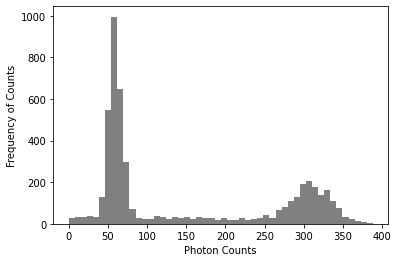

Background mean(rate*time): 60.00


In [63]:
hist = getHistogram(probDistBack,probDistSingle)
graph(hist,p0=[700, 30, 1, 200, 300, 2],fit = False)
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground))  

The integration takes a long time, this is my attempt at simulating atom loss during a measurement many times. Instead of taking an integral for each photon count, take the probability of the atom leaving the trap at time t for t from 0 to recorded time. At each of the steps change the probability that the atom will leave, then count up the amount of photons according to the status of the atom at that step(rate/totalTimeSteps). I tried taking a new sample from each dist at each step but that only created two very distinct gaussian dist far apart. I think that is interesting and it might have something to do with normal distrbutions and sample numbers. 

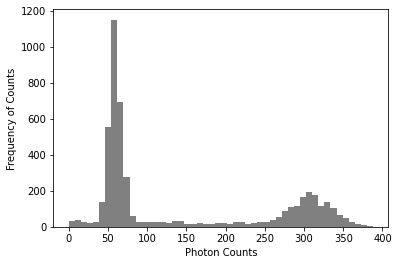

Background mean(rate*time): 60.00


In [64]:
probDistSimulated = simulateAtomLoss(recordTime,lifetimeOfTrap,xx,probDistSingle,probDistBack)
hist = getHistogram(probDistBack,probDistSimulated)
graph(hist,p0 = [700, 35, 1, 100, 125, 10],fit = False)
print ("Background mean(rate*time): %.2f" %(recordTime*rateBackground)) 